# 🤖 Robot Odometry & Event Analysis

Clean, minimal analysis of robot trajectory and experiment feedback events.

### Actual Data Sources
- **Odometry** (`/robomaster/odom`): position (x, y), orientation quaternion (converted to yaw), linear velocities (vx, vy), angular velocity (wz). Yaw (deg) and planar speed are derived here.
- **Experiment Events** (`/experiment/event`): JSON messages (via `std_msgs/String`) containing `event_type`, `action`, `details`, etc.
- **Fallback Events** (if topic missing): Matching `.jsonl` file in `experiment_logs/` whose filename corresponds to the bag directory name.

### Derived Columns & Structures
- `time_rel`: seconds since first odometry sample
- `yaw_deg`: yaw in degrees derived from odometry quaternion
- `speed`: √(vx² + vy²)
- `event_positions`: each relevant event mapped to nearest odometry pose (≤1 s difference)

### Outputs
- Static trajectory plots (with and without event overlays)
- Speed and heading statistics
- Filtered interactive trajectory explorer (dual-handle time slider) highlighting ONLY good / bad feedback events

### Feedback Event Filtering Logic (Interactive Plot)
Shown markers include only:
- `positive_feedback`
- `feedback_blink` with details containing *good* or *bad*
- Any action whose name contains *negative* or *bad*

### Next Extensions (optional)
- Smarter downsampling (RDP/event-aware)
- Export selected window stats

---
Run the cells below after setting `BAG_FILE` to your experiment bag directory.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ROS2 bag reading with rosbags library (pure Python, no ROS required)
try:
    from rosbags.rosbag2 import Reader
    from rosbags.serde import deserialize_cdr
    print("rosbags library loaded (pure Python)")
except ImportError:
    print("rosbags library not found!")
    print("Install with: pip install rosbags")ch

# Configure plotting
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 11
plt.style.use('default')

print("Ready for odometry analysis!")

rosbags library loaded (pure Python)
Ready for odometry analysis!


In [132]:
# Configuration - Update your bag file path
# BAG_FILE = "experiment_bags/exp_pregassona_1_2025-09-13T07-16-09-907Z"
BAG_FILE = "experiment_bags/exp_pregassona_2_2025-09-13T07-36-14-321Z"

# Verify bag exists
if os.path.exists(BAG_FILE):
    print(f"Bag found: {BAG_FILE}")
else:
    print(f"Bag not found: {BAG_FILE}")
    print("Update BAG_FILE path above")

print("\nExpected topics:")
print("   • /robomaster/odom (odometry data)")
print("   • /robomaster/imu (orientation)")

Bag found: experiment_bags/exp_pregassona_2_2025-09-13T07-36-14-321Z

Expected topics:
   • /robomaster/odom (odometry data)
   • /robomaster/imu (orientation)


In [133]:
# Read odometry data from bag
def read_odometry_data(bag_path):
    """Extract odometry data from ROS2 bag using rosbags library"""
    if not os.path.exists(bag_path):
        return []
    
    odom_data = []
    
    try:
        with Reader(bag_path) as reader:
            # Filter for odometry topic
            connections = [x for x in reader.connections if x.topic == '/robomaster/odom']
            
            if not connections:
                print("No /robomaster/odom topic found in bag")
                return []
            
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                # Deserialize the message
                odom_msg = deserialize_cdr(rawdata, connection.msgtype)
                
                # Extract position
                x = odom_msg.pose.pose.position.x
                y = odom_msg.pose.pose.position.y
                
                # Extract orientation (quaternion to yaw)
                qx = odom_msg.pose.pose.orientation.x
                qy = odom_msg.pose.pose.orientation.y
                qz = odom_msg.pose.pose.orientation.z
                qw = odom_msg.pose.pose.orientation.w
                yaw = np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))
                
                # Extract velocities
                vx = odom_msg.twist.twist.linear.x
                vy = odom_msg.twist.twist.linear.y
                wz = odom_msg.twist.twist.angular.z
                
                odom_data.append({
                    'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                    'x': x,
                    'y': y,
                    'yaw': yaw,
                    'yaw_deg': np.degrees(yaw),
                    'vx': vx,
                    'vy': vy,
                    'wz': wz,
                    'speed': np.sqrt(vx*vx + vy*vy)
                })
                
    except Exception as e:
        print(f"Error reading odometry: {e}")
        return []
    
    print(f"Read {len(odom_data)} odometry points")
    return odom_data

print("Odometry reader ready")

Odometry reader ready


In [134]:
# Read event data from bag
def read_event_data(bag_path):
    """Extract event data from ROS2 bag using rosbags library"""
    if not os.path.exists(bag_path):
        return []
    
    event_data = []
    
    try:
        with Reader(bag_path) as reader:
            # Filter for experiment event topic
            connections = [x for x in reader.connections if x.topic == '/experiment/event']
            
            if not connections:
                print("No /experiment/event topic found in bag")
                return []
            
            for connection, timestamp, rawdata in reader.messages(connections=connections):
                try:
                    # Deserialize the message
                    event_msg = deserialize_cdr(rawdata, connection.msgtype)
                    
                    # Parse event message (assuming it's a JSON string in std_msgs/String)
                    if hasattr(event_msg, 'data'):
                        import json
                        try:
                            event_json = json.loads(event_msg.data)
                            event_data.append({
                                'timestamp': timestamp / 1e9,  # Convert nanoseconds to seconds
                                'event_type': event_json.get('event_type', 'unknown'),
                                'action': event_json.get('action', 'unknown'),
                                'details': event_json.get('details', {}),
                                'session_id': event_json.get('session_id', '')
                            })
                        except json.JSONDecodeError:
                            # If not JSON, treat as plain string
                            event_data.append({
                                'timestamp': timestamp / 1e9,
                                'event_type': 'raw_message',
                                'action': 'message',
                                'details': {'message': event_msg.data},
                                'session_id': ''
                            })
                            
                except Exception as e:
                    print(f"Error parsing event message: {e}")
                    continue
                
    except Exception as e:
        print(f"Error reading events: {e}")
        return []
    
    print(f"Read {len(event_data)} event messages")
    return event_data

# Alternative: Read from JSONL file if bag reading fails
def read_event_data_from_jsonl(bag_path):
    """Fallback: read events from JSONL file"""
    import json
    from pathlib import Path
    
    # Try to find matching JSONL file
    bag_name = Path(bag_path).name
    jsonl_path = Path(bag_path).parent.parent / "experiment_logs" / f"{bag_name}.jsonl"
    
    if not jsonl_path.exists():
        print(f"No JSONL file found at: {jsonl_path}")
        return []
    
    event_data = []
    try:
        with open(jsonl_path, 'r') as f:
            for line in f:
                if line.strip():
                    event_json = json.loads(line.strip())
                    # Convert ISO timestamp to Unix timestamp
                    from datetime import datetime
                    iso_time = event_json.get('timestamp', '')
                    unix_time = datetime.fromisoformat(iso_time.replace('Z', '+00:00')).timestamp()
                    
                    event_data.append({
                        'timestamp': unix_time,
                        'event_type': event_json.get('event_type', 'unknown'),
                        'action': event_json.get('action', 'unknown'),
                        'details': event_json.get('details', {}),
                        'session_id': event_json.get('session_id', '')
                    })
    except Exception as e:
        print(f"Error reading JSONL: {e}")
        return []
        
    print(f"Read {len(event_data)} events from JSONL file")
    return event_data

print("Event data readers ready")

Event data readers ready


In [135]:
import numpy as np

def normalize_odometry(df, method="start", rotate_to_initial_heading=True):
    """
    Returns a *new* DataFrame with x_norm, y_norm columns.
    method: "start" -> subtract first pose; "mean" -> subtract centroid.
    rotate_to_initial_heading: if True, rotate so initial yaw becomes 0.
    """
    d = df.copy()

    if method == "start":
        x0, y0 = float(d['x'].iloc[0]), float(d['y'].iloc[0])
    elif method == "mean":
        x0, y0 = float(d['x'].mean()), float(d['y'].mean())
    else:
        raise ValueError("method must be 'start' or 'mean'")

    # shift
    d['x'] = d['x'] - x0
    d['y'] = d['y'] - y0

    # optional rotate so the initial yaw aligns with +X
    # if rotate_to_initial_heading and len(d) > 0:
    #     th0 = float(d['yaw'].iloc[0])  # radians
    #     c, s = np.cos(-th0), np.sin(-th0)
    #     xn = c * d['x'] - s * d['y']
    #     yn = s * d['x'] + c * d['y']
    #     d['x'], d['y'] = xn, yn

    return d

In [136]:
# import numpy as np

# def normalize_odometry(df, method="start", rotate_to_initial_heading=True):
#     """
#     Returns a *new* DataFrame with x_norm, y_norm columns.
#     method: "start" -> subtract first pose; "mean" -> subtract centroid.
#     rotate_to_initial_heading: if True, rotate so initial yaw becomes 0.
#     """
#     d = df.copy()

#     if method == "start":
#         x0, y0 = float(d['x'].iloc[0]), float(d['y'].iloc[0])
#     elif method == "mean":
#         x0, y0 = float(d['x'].mean()), float(d['y'].mean())
#     else:
#         raise ValueError("method must be 'start' or 'mean'")

#     # shift
#     d['x_norm'] = d['x'] - x0
#     d['y_norm'] = d['y'] - y0

#     # optional rotate so the initial yaw aligns with +X
#     if rotate_to_initial_heading and len(d) > 0:
#         th0 = float(d['yaw'].iloc[0])  # radians
#         c, s = np.cos(-th0), np.sin(-th0)
#         xn = c * d['x_norm'] - s * d['y_norm']
#         yn = s * d['x_norm'] + c * d['y_norm']
#         d['x_norm'], d['y_norm'] = xn, yn

#     return d

In [137]:
# Load and analyze odometry data
print("Loading odometry data...")

odom_data = read_odometry_data(BAG_FILE)

if not odom_data:
    print("No odometry data found!")
    print("Make sure /robomaster/odom is in your bag file")
else:
    # Convert to DataFrame
    df = pd.DataFrame(odom_data)
    df["time"] = pd.to_datetime(df["timestamp"], unit="s")
    df["time_rel"] = df["timestamp"] - df["timestamp"].iloc[0]

    # # Normalize: start at (0,0) and align heading
    # df = normalize_odometry(df, method="start", rotate_to_initial_heading=True)

    # Calculate trajectory metrics
    duration = df["time_rel"].iloc[-1]

    # Calculate distance traveled
    distances = []
    for i in range(1, len(df)):
        dx = df["x"].iloc[i] - df["x"].iloc[i - 1]
        dy = df["y"].iloc[i] - df["y"].iloc[i - 1]
        distances.append(np.sqrt(dx * dx + dy * dy))
    total_distance = sum(distances)

    # Summary statistics
    print(f"\nTRAJECTORY SUMMARY:")
    print(f"   Duration: {duration:.1f} seconds")
    print(f"   Data points: {len(df)}")
    print(f"   Total distance: {total_distance:.2f} meters")
    print(f"   X range: {df['x'].min(): .2f} to {df['x'].max(): .2f} m")
    print(f"   Y range: {df['y'].min(): .2f} to {df['y'].max(): .2f} m")
    print(
        f"   Heading range: {df['yaw_deg'].min(): .0f}° to {df['yaw_deg'].max(): .0f}°"
    )
    print(f"   Max speed: {df['speed'].max(): .2f} m/s")
    print(f"   Avg speed: {df['speed'].mean(): .2f} m/s")

    print(f"\nFirst few data points:")
    print(df[["time_rel", "x", "y", "yaw_deg", "speed"]].head())

Loading odometry data...


/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_89562/3606843681.py:20: DeprecationWarning:

Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)



Read 14378 odometry points

TRAJECTORY SUMMARY:
   Duration: 1466.0 seconds
   Data points: 14378
   Total distance: 134.65 meters
   X range: -9.19 to -1.42 m
   Y range: -1.20 to  4.14 m
   Heading range: -180° to  180°
   Max speed:  1.32 m/s
   Avg speed:  0.17 m/s

First few data points:
   time_rel        x        y  yaw_deg  speed
0  0.000000 -3.37422  1.44909   100.70   0.01
1  0.100457 -3.37422  1.44862   100.73   0.00
2  0.221453 -3.37426  1.44831   100.73   0.01
3  0.320724 -3.37431  1.44846   100.70   0.01
4  0.420409 -3.37426  1.44866   100.65   0.01


In [138]:
# Load and analyze event data
print("Loading event data...")

# Try reading from ROS2 bag first, then fallback to JSONL
event_data = read_event_data(BAG_FILE)
if not event_data:
    print("No events from bag, trying JSONL file...")
    event_data = read_event_data_from_jsonl(BAG_FILE)

if not event_data:
    print("No event data found!")
    events_df = pd.DataFrame()  # Empty dataframe
else:
    # Convert to DataFrame
    events_df = pd.DataFrame(event_data)
    
    # Align timestamps with odometry (relative to start)
    if 'df' in locals() and not df.empty:
        odom_start_time = df['timestamp'].iloc[0]
        events_df['time_rel'] = events_df['timestamp'] - odom_start_time
        
        # Filter events to trajectory timespan
        trajectory_end = df['timestamp'].iloc[-1]
        events_df = events_df[
            (events_df['timestamp'] >= odom_start_time) & 
            (events_df['timestamp'] <= trajectory_end)
        ].copy()
    else:
        events_df['time_rel'] = events_df['timestamp'] - events_df['timestamp'].iloc[0]
    
    # Categorize events by type for visualization
    feedback_events = events_df[events_df['event_type'] == 'system'].copy()
    led_events = events_df[events_df['event_type'] == 'led_control'].copy()
    sound_events = events_df[events_df['event_type'] == 'sound_control'].copy()
    movement_events = events_df[events_df['event_type'] == 'movement'].copy()

    # Arm events: either arm_control or movement events with action_name '/robomaster/move_arm_pose'
    # arm events could be in 'movement' since it was missclassified by the ros-server publisher
    arm_events = events_df[(events_df['event_type'] == 'arm_control') | 
                           ((events_df['event_type'] == 'movement') & 
                            (events_df['details'].apply(lambda d: isinstance(d, dict) and d.get('action_name') == '/robomaster/move_arm_pose')))
                          ].copy()
    
    # Identify box open (pose_type=4) and box close (pose_type=2) events
    def _pose_type(ev_details):
        if isinstance(ev_details, dict):
            return ev_details.get('goal', {}).get('pose_type')
        return None
    arm_events['pose_type'] = arm_events['details'].apply(_pose_type)
    open_box_events = arm_events[arm_events['pose_type'] == 4].copy()
    close_box_events = arm_events[arm_events['pose_type'] == 2].copy()

    print(f"   Box opening events (pose_type=4): {len(open_box_events)}")
    print(f"   Box closing events (pose_type=2): {len(close_box_events)}")

    # Summary statistics
    print(f"\nEVENT SUMMARY:")
    print(f"   Total events: {len(events_df)}")
    print(f"   System feedback: {len(feedback_events)}")
    print(f"   LED controls: {len(led_events)}")
    print(f"   Sound events: {len(sound_events)}")
    print(f"   Movement events: {len(movement_events)}")
    print(f"   Arm events: {len(arm_events)}")

    # Show interesting events
    positive_feedback = events_df[events_df['action'] == 'positive_feedback']
    if len(positive_feedback) > 0:
        print(f"   Positive feedback events: {len(positive_feedback)}")
        print(f"      Times: {positive_feedback['time_rel'].round(1).tolist()[:5]} seconds")
    
    negative_feedback = events_df[events_df['action'].str.contains('negative|bad', na=False)]
    if len(negative_feedback) > 0:
        print(f"   Negative feedback events: {len(negative_feedback)}")
    
    print(f"\n📋 Event types found:")
    print(events_df['action'].value_counts().head(10))

Loading event data...
Read 2799 event messages
   Box opening events (pose_type=4): 104
   Box closing events (pose_type=2): 104

EVENT SUMMARY:
   Total events: 2799
   System feedback: 17
   LED controls: 714
   Sound events: 153
   Movement events: 1901
   Arm events: 208
   Positive feedback events: 17
      Times: [195.5, 274.9, 289.1, 316.9, 397.2] seconds

📋 Event types found:
action
joystick_move               961
set_color                   658
joystick_start              358
joystick_end                358
play_sound                  137
generic_action              111
generic_action_completed    111
feedback_blink               56
positive_feedback            17
happy_chime_sequence         16
Name: count, dtype: int64


/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_89562/1532021912.py:21: DeprecationWarning:

Global serialization/deserialization functions have been replaced with
explicit typestores.

If you are deserializing messages from an AnyReader instance, simply
use its `.deserialize(data, typename)` method.

Otherwise instantiate a type store and use its methods:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.deserialize_cdr(data, typename)



In [139]:
# Function to find robot position at event times
def get_robot_position_at_events(odom_df, events_df):
    """Find robot position when each event occurred"""
    event_positions = []
    
    for _, event in events_df.iterrows():
        event_time = event['timestamp']
        
        # Find closest odometry point
        time_diffs = np.abs(odom_df['timestamp'] - event_time)
        closest_idx = time_diffs.idxmin()
        
        if time_diffs.iloc[closest_idx] < 1.0:  # Within 1 second
            robot_pos = {
                'event_time': event['time_rel'],
                'event_type': event['event_type'],
                'action': event['action'],
                'x': odom_df.loc[closest_idx, 'x'],
                'y': odom_df.loc[closest_idx, 'y'],
                'yaw': odom_df.loc[closest_idx, 'yaw'],
                'details': event.get('details', {})
            }
            event_positions.append(robot_pos)
    
    return pd.DataFrame(event_positions)

# Get event positions
if 'df' in locals() and 'events_df' in locals() and not events_df.empty:
    event_positions = get_robot_position_at_events(df, events_df)
    print(f"Mapped {len(event_positions)} events to robot positions")
    
    if len(event_positions) > 0:
        print(f"\nEvents on trajectory:")
        for event_type in event_positions['event_type'].unique():
            count = len(event_positions[event_positions['event_type'] == event_type])
            print(f"   • {event_type}: {count} events")
else:
    event_positions = pd.DataFrame()
    print("No events to map to positions")

Mapped 2799 events to robot positions

Events on trajectory:
   • movement: 1901 events
   • sound_control: 153 events
   • led_control: 714 events
   • system: 17 events
   • gripper_control: 14 events


In [140]:
# Detailed Speed Analysis
def analyze_robot_speed_patterns(odom_df, events_df=None, event_positions=None):
    """Analyze robot speed patterns and correlate with events"""
    
    if odom_df.empty:
        print("No odometry data available for speed analysis")
        return
    
    # Calculate speed statistics
    speed_stats = {
        'mean_speed': odom_df['speed'].mean(),
        'max_speed': odom_df['speed'].max(),
        'min_speed': odom_df['speed'].min(),
        'std_speed': odom_df['speed'].std()
    }
    
    # Define speed thresholds
    high_speed_threshold = speed_stats['mean_speed'] + speed_stats['std_speed']
    low_speed_threshold = speed_stats['mean_speed'] - speed_stats['std_speed']
    
    # Identify speed periods
    high_speed_periods = odom_df[odom_df['speed'] > high_speed_threshold]
    low_speed_periods = odom_df[odom_df['speed'] < low_speed_threshold]
    
    print("Speed Analysis Summary:")
    print(f"   • Average speed: {speed_stats['mean_speed']:.3f} m/s")
    print(f"   • Max speed: {speed_stats['max_speed']:.3f} m/s")
    print(f"   • Min speed: {speed_stats['min_speed']:.3f} m/s")
    print(f"   • Speed std dev: {speed_stats['std_speed']:.3f} m/s")
    print(f"   • High speed periods (>{high_speed_threshold:.3f} m/s): {len(high_speed_periods)} points")
    print(f"   • Low speed periods (<{low_speed_threshold:.3f} m/s): {len(low_speed_periods)} points")
    
    # Analyze speed near events
    if event_positions is not None and not event_positions.empty:
        print(f"\nSpeed near events:")
        
        # Analyze speed around each event type
        for event_type in event_positions['event_type'].unique():
            type_events = event_positions[event_positions['event_type'] == event_type]
            speeds_near_events = []
            
            for _, event in type_events.iterrows():
                # Find robot speed within 2 seconds of event
                time_window = 2.0  # seconds
                event_time = event['event_time']
                
                nearby_data = odom_df[
                    (odom_df['time_rel'] >= event_time - time_window) & 
                    (odom_df['time_rel'] <= event_time + time_window)
                ]
                
                if not nearby_data.empty:
                    speeds_near_events.extend(nearby_data['speed'].tolist())
            
            if speeds_near_events:
                avg_speed_near = np.mean(speeds_near_events)
                print(f"   • {event_type}: avg speed {avg_speed_near:.3f} m/s (vs overall {speed_stats['mean_speed']:.3f})")
                
                # Check if significantly slower
                if avg_speed_near < speed_stats['mean_speed'] * 0.8:
                    print(f"     → Robot slows down significantly near {event_type} events!")
    
    return speed_stats, high_speed_threshold, low_speed_threshold

# Run speed analysis
if 'df' in locals() and not df.empty:
    speed_stats, high_thresh, low_thresh = analyze_robot_speed_patterns(
        df, 
        events_df if 'events_df' in locals() else None,
        event_positions if 'event_positions' in locals() else None
    )
else:
    print("No trajectory data available for speed analysis")

Speed Analysis Summary:
   • Average speed: 0.167 m/s
   • Max speed: 1.320 m/s
   • Min speed: 0.000 m/s
   • Speed std dev: 0.172 m/s
   • High speed periods (>0.338 m/s): 2387 points
   • Low speed periods (<-0.005 m/s): 0 points

Speed near events:
   • movement: avg speed 0.192 m/s (vs overall 0.167)
   • sound_control: avg speed 0.105 m/s (vs overall 0.167)
     → Robot slows down significantly near sound_control events!
   • led_control: avg speed 0.109 m/s (vs overall 0.167)
     → Robot slows down significantly near led_control events!
   • system: avg speed 0.103 m/s (vs overall 0.167)
     → Robot slows down significantly near system events!
   • gripper_control: avg speed 0.043 m/s (vs overall 0.167)
     → Robot slows down significantly near gripper_control events!


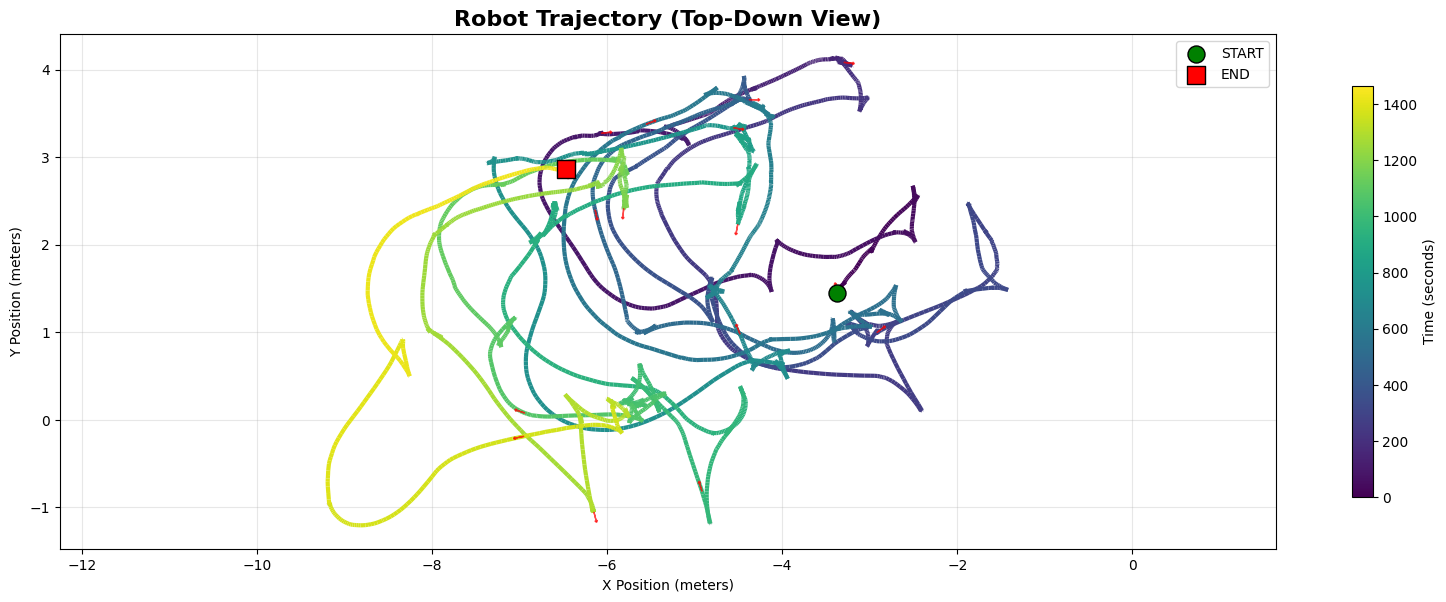

In [141]:
# Visualize trajectory
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # 1. Main 2D trajectory plot
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=150, marker='o', label='START', zorder=10, edgecolor='black')
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=150, marker='s', label='END', zorder=10, edgecolor='black')
    
    # Add orientation arrows
    N = max(1, len(df) // 15)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.1
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.03, head_length=0.02, 
                 fc='red', ec='red', alpha=0.7, zorder=5)
    
    ax1.set_title('Robot Trajectory (Top-Down View)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Colorbar
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No trajectory data to visualize")

In [142]:
# Interactive trajectory visualization with a SIMPLE dual-handle time slider
# Shows GOOD/BAD feedback + BOX OPEN/CLOSE events with clearer symbols.
# Added precision controls: step size dropdown + manual start/end inputs.
# Slider width increased for finer control.

# Add a frame around the plot for export clarity and option to hide legend and speed colorbar.
try:
    import plotly.io as pio
    import plotly.graph_objects as go
    import numpy as np
    import pandas as pd
    from ipywidgets import (
        FloatRangeSlider,
        VBox,
        HTML,
        HBox,
        Button,
        Layout,
        Dropdown,
        FloatText,
        Label,
        Checkbox,
    )
    from IPython.display import display
    import pytz
    import tzlocal

    PLOTLY_OK = True
except ImportError as e:
    print("Required libraries missing.")
    print("Install with: pip install plotly ipywidgets pytz tzlocal kaleido")
    PLOTLY_OK = False


def create_time_range_slider_widget(df, event_positions=None, max_points=15000):
    """Return a VBox containing a FigureWidget and a dual-handle time range slider with precision controls.

    Event display policy:
      - Feedback: positive, negative/bad, feedback_blink with good/bad
      - Box open (pose_type=4) and box close (pose_type=2)
    Precision controls:
      - Step size dropdown (1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01)
      - Manual start/end FloatText boxes (auto-snap within bounds)
      - Checkbox to hide/show legend and speed colorbar
    """
    if df.empty:
        return HTML("<b>No data</b>")

    if len(df) > max_points:
        step = int(np.ceil(len(df) / max_points))
        base_df = df.iloc[::step].copy()
        print(
            f"⚡ Downsampled from {len(df)} to {len(base_df)} points for interaction speed"
        )
    else:
        base_df = df.copy()

    time_rel = base_df["time_rel"].to_numpy()
    speed = base_df["speed"].to_numpy()
    # x_vals = base_df["x_norm"].to_numpy()
    # y_vals = base_df["y_norm"].to_numpy()
    x_vals = base_df["x"].to_numpy()
    y_vals = base_df["y"].to_numpy()
    yaw_deg_vals = base_df["yaw_deg"].to_numpy()
    timestamp_vals = base_df["timestamp"].to_numpy()
    local_tz = tzlocal.get_localzone()
    time_dt = (
        pd.to_datetime(timestamp_vals, unit="s").tz_localize("UTC").tz_convert(local_tz)
    )

    # Add frame using shapes in layout
    plot_width = 1200
    plot_height = 1200
    fig = go.FigureWidget(
        layout=dict(
            width=plot_width,
            height=plot_height,
            # title=dict(text='Robot Trajectory (Time-Windowed)', x=0.5, font=dict(size=22)),
            plot_bgcolor="white",
            paper_bgcolor="white",
            margin=dict(
                l=60, r=40, t=90, b=80
            ),  # reduced bottom margin since colorbar now inside plot
            xaxis=dict(
                title=dict(
                    text="Lateral motion (m)", font=dict(color="black", size=16)
                ),
                tickfont=dict(size=18, color="black"),
                showgrid=True,
                gridcolor="lightgray",
                zeroline=True,
                zerolinecolor="lightgray",
                zerolinewidth=1,
                # range=xlim,
            ),
            yaxis=dict(
                title=dict(
                    text="Forward motion (m)", font=dict(color="black", size=16)
                ),
                tickfont=dict(size=18, color="black"),
                showgrid=True,
                gridcolor="lightgray",
                zeroline=True,
                zerolinecolor="lightgray",
                zerolinewidth=1,
                scaleanchor="x",
                scaleratio=1,
                # range=ylim,
            ),
            hovermode="closest",
            legend=dict(orientation="v", font=dict(size=14)),
            shapes=[
                dict(
                    type="rect",
                    xref="paper",
                    yref="paper",
                    x0=0,
                    y0=0,
                    x1=1,
                    y1=1,
                    line=dict(color="black", width=1),
                    fillcolor="rgba(0,0,0,0)",
                )
            ],
        )
    )

    full_path = go.Scatter(
        x=x_vals,
        y=y_vals,
        mode="lines",
        line=dict(color="rgba(150,150,150,0.30)", width=3),
        name="Full Path",
        hoverinfo="skip",
    )

    # Colored line by speed: create segments, each as a separate trace
    segment_traces = []
    from matplotlib import cm
    import matplotlib.colors as mcolors

    norm = mcolors.Normalize(vmin=speed.min(), vmax=speed.max())
    cmap = cm.get_cmap("plasma")
    for i in range(len(x_vals) - 1):
        seg_x = [x_vals[i], x_vals[i + 1]]
        seg_y = [y_vals[i], y_vals[i + 1]]
        seg_speed = speed[i]
        color = mcolors.to_hex(cmap(norm(seg_speed)))
        segment_traces.append(
            go.Scatter(
                x=seg_x,
                y=seg_y,
                mode="lines",
                line=dict(color=color, width=4),
                hoverinfo="skip",
                showlegend=False,
            )
        )

    # Vertical colorbar INSIDE the plot on the right side
    colorbar_trace = go.Scatter(
        x=[None],
        y=[None],
        mode="markers",
        marker=dict(
            colorscale="Plasma",
            cmin=speed.min(),
            cmax=speed.max(),
            color=[speed.min(), speed.max()],
            colorbar=dict(
                title=dict(
                    text="Speed (m/s)", font=dict(color="black", size=12)
                ),  # ← title in black
                tickfont=dict(color="black", size=14),  # ← numbers in black
                len=0.6,
                thickness=15,
                orientation="v",
                x=0.96,
                xanchor="right",
                y=0.5,
                yanchor="middle",
                outlinewidth=1,
                outlinecolor="black",
                bgcolor="rgba(255,255,255,0.85)",
                ticklen=5,
            ),
        ),
        hoverinfo="none",
        showlegend=False,
    )

    # Important event points (good/bad feedback, box open/close)
    good_x = good_y = bad_x = bad_y = open_x = open_y = close_x = close_y = np.array([])
    good_times = bad_times = open_times = close_times = None

    if event_positions is not None and not event_positions.empty:
        ev = event_positions.copy()
        ev["action_str"] = ev["action"].astype(str).str.lower()
        details_str = (
            ev.get("details", pd.Series([{}] * len(ev))).astype(str).str.lower()
        )

        good_mask = (ev["action_str"] == "positive_feedback") | (
            (ev["action_str"] == "feedback_blink") & details_str.str.contains("good")
        )
        bad_mask = ev["action_str"].str.contains("negative|bad") | (
            (ev["action_str"] == "feedback_blink") & details_str.str.contains("bad")
        )

        global open_box_events, close_box_events
        if "open_box_events" in globals() and len(open_box_events) > 0:
            open_times = (
                open_box_events["time_rel"].to_numpy(dtype=float)
                if "time_rel" in open_box_events.columns
                else (open_box_events["timestamp"] - df["timestamp"].iloc[0]).to_numpy(
                    dtype=float
                )
            )
        if "close_box_events" in globals() and len(close_box_events) > 0:
            close_times = (
                close_box_events["time_rel"].to_numpy(dtype=float)
                if "time_rel" in close_box_events.columns
                else (close_box_events["timestamp"] - df["timestamp"].iloc[0]).to_numpy(
                    dtype=float
                )
            )

        def map_box_positions(box_times):
            if box_times is None:
                return np.array([]), np.array([])
            xs = []
            ys = []
            for bt in box_times:
                diffs = np.abs(ev["event_time"] - bt)
                if len(diffs):
                    idx = diffs.idxmin()
                    if diffs.loc[idx] < 0.6:
                        xs.append(ev.loc[idx, "x"])
                        ys.append(ev.loc[idx, "y"])
            return np.array(xs), np.array(ys)

        if good_mask.any():
            good_subset = ev[good_mask]
            good_times = good_subset["event_time"].to_numpy(dtype=float)
            good_x = good_subset["x"].to_numpy()
            good_y = good_subset["y"].to_numpy()
        if bad_mask.any():
            bad_subset = ev[bad_mask]
            bad_times = bad_subset["event_time"].to_numpy(dtype=float)
            bad_x = bad_subset["x"].to_numpy()
            bad_y = bad_subset["y"].to_numpy()

        open_x, open_y = map_box_positions(open_times)
        close_x, close_y = map_box_positions(close_times)

    # Add event markers back
    good_trace = go.Scatter(
        x=good_x,
        y=good_y,
        mode="markers",
        marker=dict(
            size=14, color="gold", symbol="star", line=dict(width=2, color="orange")
        ),
        name="Good Feedback",
    )
    bad_trace = go.Scatter(
        x=bad_x,
        y=bad_y,
        mode="markers",
        marker=dict(
            size=12, color="lightcoral", symbol="x", line=dict(width=2, color="red")
        ),
        name="Bad / Negative",
    )
    open_trace = go.Scatter(
        x=open_x,
        y=open_y,
        mode="markers",
        marker=dict(
            size=20,
            color="white",
            symbol="triangle-up",
            line=dict(width=3, color="darkgreen"),
        ),
        name="Box Open",
    )
    close_trace = go.Scatter(
        x=close_x,
        y=close_y,
        mode="markers",
        marker=dict(
            size=20,
            color="darkred",
            symbol="triangle-down",
            line=dict(width=2, color="white"),
        ),
        name="Box Close",
    )

    start_marker = go.Scatter(
        x=[df["x"].iloc[0]],
        y=[df["y"].iloc[0]],
        mode="markers",
        marker=dict(size=16, color="lime", line=dict(width=3, color="darkgreen")),
        name="Start",
    )
    end_marker = go.Scatter(
        x=[df["x"].iloc[-1]],
        y=[df["y"].iloc[-1]],
        mode="markers",
        marker=dict(
            size=16, color="red", symbol="square", line=dict(width=3, color="darkred")
        ),
        name="End",
    )

    # Add all traces to the figure
    fig.add_traces(
        [full_path]
        + segment_traces
        + [
            colorbar_trace,
            start_marker,
            end_marker,
            good_trace,
            bad_trace,
            open_trace,
            close_trace,
        ]
    )

    t_min = float(time_rel.min())
    t_max = float(time_rel.max())

    # Precision controls
    step_selector = Dropdown(
        options=[
            ("1.0 s", "1.0"),
            ("0.5 s", "0.5"),
            ("0.2 s", "0.2"),
            ("0.1 s", "0.1"),
            ("0.05 s", "0.05"),
            ("0.02 s", "0.02"),
            ("0.01 s", "0.01"),
        ],
        value="0.1",
        description="Step",
        layout=Layout(width="130px"),
    )
    slider = FloatRangeSlider(
        value=(t_min, t_max),
        min=t_min,
        max=t_max,
        step=0.1,
        description="Time (s)",
        readout=False,
        continuous_update=True,
        layout=Layout(width="1000px"),  # widened from 750px
    )
    start_input = FloatText(
        value=t_min, description="Start", layout=Layout(width="180px")
    )
    end_input = FloatText(value=t_max, description="End", layout=Layout(width="180px"))
    stats_label = HTML()
    warn_label = HTML()
    legend_checkbox = Checkbox(
        value=True, description="Show Legend & Speedbar", layout=Layout(width="180px")
    )

    MIN_DELTA = 0.0005  # Minimum allowable span

    def clamp(v):
        return float(np.clip(v, t_min, t_max))

    def apply_inputs_to_slider():
        s0 = clamp(start_input.value)
        s1 = clamp(end_input.value)
        if s1 - s0 < MIN_DELTA:
            s1 = min(t_max, s0 + MIN_DELTA)
        slider.value = (s0, s1)

    def on_step_change(change):
        try:
            new_step = float(change["new"])
            slider.step = new_step
        except Exception:
            pass

    step_selector.observe(on_step_change, names="value")

    def on_start_change(change):
        apply_inputs_to_slider()

    def on_end_change(change):
        apply_inputs_to_slider()

    start_input.observe(on_start_change, names="value")
    end_input.observe(on_end_change, names="value")

    def on_legend_toggle(change):
        fig.layout.showlegend = change["new"]
        # Hide/show speed colorbar by toggling its visibility
        if change["new"]:
            colorbar_trace.marker.colorbar.len = 0.6
            colorbar_trace.marker.colorbar.title = "Speed (m/s)"
            colorbar_trace.visible = True
        else:
            colorbar_trace.marker.colorbar.len = 0.0001  # effectively hides the bar
            colorbar_trace.marker.colorbar.title = ""
            colorbar_trace.visible = False

    legend_checkbox.observe(on_legend_toggle, names="value")
    fig.layout.showlegend = False
    # fig.layout.showlegend = legend_checkbox.value
    # Initial colorbar state
    # if not legend_checkbox.value:
    #     colorbar_trace.marker.colorbar.len = 0.0001
    #     colorbar_trace.marker.colorbar.title = ""
    #     colorbar_trace.visible = False

    def update_range(_=None):
        t0, t1 = slider.value
        # sync inputs if user dragged slider
        start_input.value = t0
        end_input.value = t1
        mask = (time_rel >= t0) & (time_rel <= t1)
        # Update segment traces for selected window
        for i, trace in enumerate(segment_traces):
            if mask[i] and mask[i + 1]:
                trace.x = [x_vals[i], x_vals[i + 1]]
                trace.y = [y_vals[i], y_vals[i + 1]]
            else:
                trace.x = []
                trace.y = []
        dx = np.diff(x_vals[mask])
        dy = np.diff(y_vals[mask])
        seg_len = np.sqrt(dx * dx + dy * dy).sum() if mask.any() else 0
        abs_start = time_dt[mask][0] if mask.any() else None
        abs_end = time_dt[mask][-1] if mask.any() else None
        stats_label.value = (
            f"<span style='color:gray; font-size:14px'>"
            f"Window: {t0:.4f}s – {t1:.4f}s (Δ={(t1-t0):.4f}s) | "
            f"Absolute: {abs_start.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] if abs_start else '-'} – {abs_end.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] if abs_end else '-'}<br>"
            f"Points: {mask.sum()} | Path length: {seg_len:.2f} m"
            f"</span>"
        )
        warn_label.value = (
            "" if mask.any() else "<span style='color:red'>Empty selection</span>"
        )
        # Update event markers for selected window
        if good_times is not None:
            gmask = (good_times >= t0) & (good_times <= t1)
            good_trace.x = good_x[gmask] if gmask.any() else []
            good_trace.y = good_y[gmask] if gmask.any() else []
        if bad_times is not None:
            bmask = (bad_times >= t0) & (bad_times <= t1)
            bad_trace.x = bad_x[bmask] if bmask.any() else []
            bad_trace.y = bad_y[bmask] if bmask.any() else []
        if open_times is not None:
            omask = (open_times >= t0) & (open_times <= t1)
            open_trace.x = open_x[omask] if omask.any() else []
            open_trace.y = open_y[omask] if omask.any() else []
        if close_times is not None:
            cmask = (close_times >= t0) & (close_times <= t1)
            close_trace.x = close_x[cmask] if cmask.any() else []
            close_trace.y = close_y[cmask] if cmask.any() else []

    slider.observe(update_range, names="value")
    update_range()

    # Export configuration and helper functions
    EXPORT_W, EXPORT_H = 1200, 1200  # match your layout

    def snapshot_current_figure(fig_widget):
        """Deep snapshot of the interactive FigureWidget (keeps filters/toggles)."""
        # Create a new figure with the exact current state
        snap = go.Figure()

        # Copy each trace with its current data state (including empty arrays from filtering)
        for trace in fig_widget.data:
            # Create a new trace that preserves the current filtered state
            trace_dict = {
                "x": list(trace.x) if trace.x is not None else [],
                "y": list(trace.y) if trace.y is not None else [],
                "mode": trace.mode,
                "name": trace.name,
                "hoverinfo": trace.hoverinfo,
                "showlegend": trace.showlegend,
                "visible": trace.visible,
            }

            # Handle line properties if they exist
            if trace.line:
                trace_dict["line"] = {}
                if hasattr(trace.line, "color") and trace.line.color:
                    trace_dict["line"]["color"] = trace.line.color
                if hasattr(trace.line, "width") and trace.line.width:
                    trace_dict["line"]["width"] = trace.line.width

            # Handle marker properties if they exist
            if trace.marker:
                trace_dict["marker"] = {}
                if hasattr(trace.marker, "color") and trace.marker.color is not None:
                    trace_dict["marker"]["color"] = trace.marker.color
                if hasattr(trace.marker, "size") and trace.marker.size:
                    trace_dict["marker"]["size"] = trace.marker.size
                if hasattr(trace.marker, "symbol") and trace.marker.symbol:
                    trace_dict["marker"]["symbol"] = trace.marker.symbol
                if hasattr(trace.marker, "line") and trace.marker.line:
                    trace_dict["marker"]["line"] = {}
                    if hasattr(trace.marker.line, "color") and trace.marker.line.color:
                        trace_dict["marker"]["line"]["color"] = trace.marker.line.color
                    if hasattr(trace.marker.line, "width") and trace.marker.line.width:
                        trace_dict["marker"]["line"]["width"] = trace.marker.line.width
                # Handle colorbar if present
                if hasattr(trace.marker, "colorbar") and trace.marker.colorbar:
                    colorbar_dict = {}
                    cb = trace.marker.colorbar
                    # Copy colorbar properties individually to avoid dict() constructor issues
                    if hasattr(cb, "title") and cb.title:
                        colorbar_dict["title"] = cb.title
                    if hasattr(cb, "tickfont") and cb.tickfont:
                        colorbar_dict["tickfont"] = cb.tickfont
                    if hasattr(cb, "len") and cb.len is not None:
                        colorbar_dict["len"] = cb.len
                    if hasattr(cb, "thickness") and cb.thickness:
                        colorbar_dict["thickness"] = cb.thickness
                    if hasattr(cb, "orientation") and cb.orientation:
                        colorbar_dict["orientation"] = cb.orientation
                    if hasattr(cb, "x") and cb.x is not None:
                        colorbar_dict["x"] = cb.x
                    if hasattr(cb, "xanchor") and cb.xanchor:
                        colorbar_dict["xanchor"] = cb.xanchor
                    if hasattr(cb, "y") and cb.y is not None:
                        colorbar_dict["y"] = cb.y
                    if hasattr(cb, "yanchor") and cb.yanchor:
                        colorbar_dict["yanchor"] = cb.yanchor
                    if hasattr(cb, "outlinewidth") and cb.outlinewidth:
                        colorbar_dict["outlinewidth"] = cb.outlinewidth
                    if hasattr(cb, "outlinecolor") and cb.outlinecolor:
                        colorbar_dict["outlinecolor"] = cb.outlinecolor
                    if hasattr(cb, "bgcolor") and cb.bgcolor:
                        colorbar_dict["bgcolor"] = cb.bgcolor
                    if hasattr(cb, "ticklen") and cb.ticklen:
                        colorbar_dict["ticklen"] = cb.ticklen
                    trace_dict["marker"]["colorbar"] = colorbar_dict
                # Handle colorscale if present
                if hasattr(trace.marker, "colorscale") and trace.marker.colorscale:
                    trace_dict["marker"]["colorscale"] = trace.marker.colorscale
                if hasattr(trace.marker, "cmin") and trace.marker.cmin is not None:
                    trace_dict["marker"]["cmin"] = trace.marker.cmin
                if hasattr(trace.marker, "cmax") and trace.marker.cmax is not None:
                    trace_dict["marker"]["cmax"] = trace.marker.cmax

            new_trace = go.Scatter(**trace_dict)
            snap.add_trace(new_trace)

        # Copy the exact layout
        snap.update_layout(fig_widget.layout)

        return snap

    def export_current(fig_widget, fmt="pdf", filename="trajectory"):
        """Unified export helper (same size for PDF & PNG)"""
        snap = snapshot_current_figure(fig_widget)
        snap.update_layout(width=EXPORT_W, height=EXPORT_H)  # enforce size
        snap.write_image(f"{filename}.{fmt}", format=fmt, engine="kaleido", scale=1)

    reset_btn = Button(description="Reset", layout=Layout(width="70px"))
    export_btn = Button(description="Export PDF", layout=Layout(width="100px"))
    export_png_btn = Button(description="Export PNG", layout=Layout(width="110px"))

    def do_reset(_):
        slider.value = (t_min, t_max)
        step_selector.value = "0.1"
        slider.step = 0.1

    def do_export(_):
        try:
            from datetime import datetime

            t0, t1 = slider.value
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            base = f"robot_trajectory_{ts}_t{t0:.2f}-{t1:.2f}s"

            # PDF (vector), identical size to PNG
            export_current(fig, fmt="pdf", filename=base)

            warn_label.value = f"<span style='color:green; font-weight:bold'>✓ Exported: {base}.pdf</span>"
        except Exception as e:
            warn_label.value = f"<span style='color:red'>Export failed: {e}<br>Install with: pip install kaleido</span>"

    def do_export_png(_):
        try:
            from datetime import datetime

            t0, t1 = slider.value
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            base = f"robot_trajectory_{ts}_t{t0:.2f}-{t1:.2f}s"
            export_current(fig, fmt="png", filename=base)  # scale=1 inside
            warn_label.value = f"<span style='color:green; font-weight:bold'>✓ Exported: {base}.png</span>"
        except Exception as e:
            warn_label.value = f"<span style='color:red'>PNG export failed: {e}</span>"

    reset_btn.on_click(do_reset)
    # export_btn.on_click(do_export)
    # export directly without pressing button
    do_export(None)
    export_png_btn.on_click(do_export_png)

    header = HTML(
        "<b style='font-size:15px'>Select time window — Feedback + Box Open (▲) / Close (▼).<br>Use Step dropdown or manual Start/End for fine precision. Export PDF/PNG saves current view with identical size & filters.</b>"
    )

    controls_row1 = HBox([slider])
    controls_row2 = HBox(
        [
            step_selector,
            reset_btn,
            export_btn,
            export_png_btn,
            start_input,
            end_input,
            legend_checkbox,
        ]
    )

    return VBox([header, controls_row1, controls_row2, stats_label, warn_label, fig])


if PLOTLY_OK and "df" in locals() and not df.empty:
    print(
        "Building interactive range slider visualization (feedback + box events) with precision controls ..."
    )
    try:
        # widget = create_time_range_slider_widget(
        #     df, event_positions if "event_positions" in locals() else None
        # )
        widget = create_time_range_slider_widget(df)
        # display(widget)
        print("Ready. Adjust the slider or use Start/End boxes for precise selection.")
    except Exception as e:
        print(f"Failed to build widget: {e}")
        print(
            "If ipywidgets is not enabled, run: pip install plotly ipywidgets pytz tzlocal kaleido"
        )
else:
    if not PLOTLY_OK:
        print("Plotly/ipywidgets unavailable.")
    else:
        print("No trajectory data available for interactive visualization")

Building interactive range slider visualization (feedback + box events) with precision controls ...


/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_89562/1178476863.py:143: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/var/folders/98/v8ztsv9j68jbywz9_nz00_4m0000gn/T/ipykernel_89562/1178476863.py:567: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Ready. Adjust the slider or use Start/End boxes for precise selection.
